In [1]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch
import numpy as np
import PIL
import matplotlib.pyplot as plt
import math
import tqdm
import datetime
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [5]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [6]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [7]:
IMAGE_SHAPE = (32, 32)

In [8]:
diffusion_model = DiffusionModel()

In [9]:
class swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)

In [10]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        self.linear1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = swish()
        self.linear2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        emb = self.act(self.linear1(emb))
        emb = self.linear2(emb)
        return emb

In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, in_channels, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads
        assert in_channels % num_heads == 0
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, -1).permute(0, 2, 1, 3)
        key = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, -1).permute(0, 2, 3, 1)
        value = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, -1).permute(0, 2, 1, 3)

        energy = torch.matmul(query, key) / math.sqrt(self.head_dim)
        attention = torch.softmax(energy, dim=-1)

        out = torch.matmul(attention, value).permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, channels, height, width)
        out = self.gamma * out + x
        return out

In [14]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        self.embeddings_dims = embedding_dims
        self.embedding = SinusoidalEmbedding(self.embeddings_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.activation = swish()
        self.downsample = downsample
        if self.downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding = 1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding = 1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
        
        self.num_heads = 0
        if channels_out == 64 or 128:
            self.num_heads = 8
        elif channels_out == 256 or 512:
            self.num_heads = 16
        elif channels_out == 1024:
            self.num_heads = 32
        self.Attention = MultiHeadSelfAttention(channels_out, self.num_heads)
        self.norm1 = nn.BatchNorm2d(channels_out)
        self.norm2 = nn.BatchNorm2d(channels_out)
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding = 1)
        self.time_mlp = nn.Linear(embedding_dims, channels_out)

    def forward(self, x, t ,**kwargs):
        o = self.norm1(self.activation(self.conv1(x)))
        o_time = self.activation(self.time_mlp(self.embedding(t)))
        o = self.Attention(o + o_time[(..., ) + (None, ) * 2])
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.activation(self.label_mlp(label))
            o = self.Attention(o + o_label[(..., ) + (None, ) * 2])
            o = self.norm2(self.activation(self.conv2(o)))
        return self.final(o)

In [15]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [16]:
transform = transforms.Compose([
#     transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
#     transforms.Lambda(lambda t: t / 255.),
    transforms.Lambda(lambda t: (t * 2) - 1),
])

In [17]:
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
#     transforms.ToPILImage(),
])

In [18]:
BATCH_SIZE = 128
NO_EPOCHS = 100
PRINT_FREQUENCY = 1
SAVE_FREQUENCY = 10
LR = 0.001
VERBOSE = True
WEIGHT_DECAY = 1e-5
LR_STEP_SIZE = 30
LR_GAMMA = 0.5
num_workers = 2

unet = UNet(labels=True)
# unet = nn.DataParallel(unet)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

In [17]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:03<00:00, 55527629.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/tmp/ipykernel_28/164176903.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


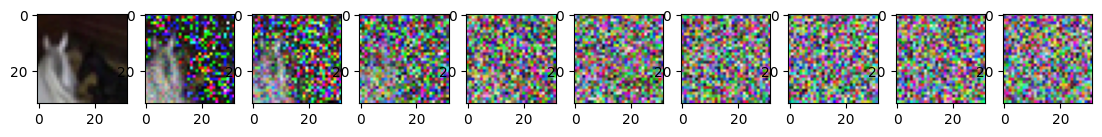

In [18]:
image = next(iter(trainloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(300/num_images)
for idx in range(0, 300, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = diffusion_model.forward(image, t, device=device)
    if len(img.shape) == 4:
        img = img[0, :, :, :] 
    plt.imshow(reverse_transform(img))

plt.show()

Training Start Time: 02:29:19PM


  1%|          | 1/100 [03:55<6:28:17, 235.33s/it]

---
Epoch: 1 | Mean Train Loss 0.19775769444994437 | Mean Val Loss 0.08629347527256379
Execution Time 02:33:14PM | Duration 235.3286862373352


  2%|▏         | 2/100 [07:42<6:16:34, 230.56s/it]

---
Epoch: 2 | Mean Train Loss 0.10884568786773927 | Mean Val Loss 0.07964463961812165
Execution Time 02:37:01PM | Duration 227.21267223358154


  3%|▎         | 3/100 [11:25<6:07:24, 227.26s/it]

---
Epoch: 3 | Mean Train Loss 0.09154454582394697 | Mean Val Loss 0.07724143612461212
Execution Time 02:40:45PM | Duration 223.3312907218933


  4%|▍         | 4/100 [15:06<5:59:41, 224.81s/it]

---
Epoch: 4 | Mean Train Loss 0.08451187666027973 | Mean Val Loss 0.07576073825550385
Execution Time 02:44:26PM | Duration 221.0486397743225


  5%|▌         | 5/100 [18:44<5:52:04, 222.37s/it]

---
Epoch: 5 | Mean Train Loss 0.08028641718511398 | Mean Val Loss 0.07389493606602535
Execution Time 02:48:04PM | Duration 218.03976249694824


  6%|▌         | 6/100 [22:22<5:45:43, 220.68s/it]

---
Epoch: 6 | Mean Train Loss 0.07850948180525731 | Mean Val Loss 0.06828927879150097
Execution Time 02:51:41PM | Duration 217.39211440086365


  7%|▋         | 7/100 [25:59<5:40:12, 219.49s/it]

---
Epoch: 7 | Mean Train Loss 0.07640446624121605 | Mean Val Loss 0.0695186615563356
Execution Time 02:55:18PM | Duration 217.04032111167908


  8%|▊         | 8/100 [29:36<5:35:24, 218.75s/it]

---
Epoch: 8 | Mean Train Loss 0.07592679741672981 | Mean Val Loss 0.06970806821034504
Execution Time 02:58:55PM | Duration 217.15711641311646


  9%|▉         | 9/100 [33:13<5:30:52, 218.15s/it]

---
Epoch: 9 | Mean Train Loss 0.07366106144319742 | Mean Val Loss 0.06989571146475963
Execution Time 03:02:32PM | Duration 216.84965705871582
---
Epoch: 10 | Mean Train Loss 0.07417576036965236 | Mean Val Loss 0.06792003116928615


<Figure size 1500x1500 with 0 Axes>

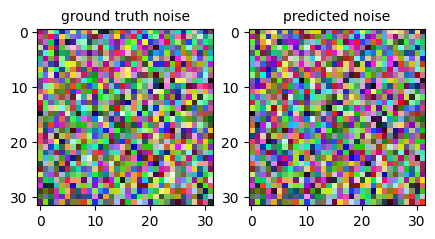

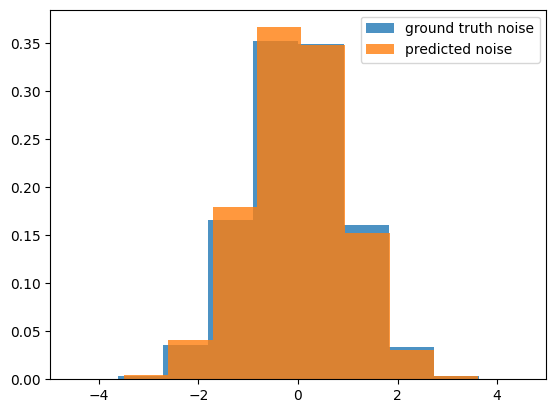

 10%|█         | 10/100 [36:51<5:27:13, 218.15s/it]

Execution Time 03:06:10PM | Duration 218.13954973220825


 11%|█         | 11/100 [40:28<5:22:59, 217.75s/it]

---
Epoch: 11 | Mean Train Loss 0.0725350250227329 | Mean Val Loss 0.06723690501008278
Execution Time 03:09:47PM | Duration 216.82830929756165


 12%|█▏        | 12/100 [44:04<5:18:47, 217.36s/it]

---
Epoch: 12 | Mean Train Loss 0.07291572270676111 | Mean Val Loss 0.06537679888499089
Execution Time 03:13:24PM | Duration 216.47314429283142


 13%|█▎        | 13/100 [47:40<5:14:35, 216.95s/it]

---
Epoch: 13 | Mean Train Loss 0.07192642494845085 | Mean Val Loss 0.066902465497454
Execution Time 03:17:00PM | Duration 216.0220263004303


 14%|█▍        | 14/100 [51:16<5:10:22, 216.54s/it]

---
Epoch: 14 | Mean Train Loss 0.07078736862884118 | Mean Val Loss 0.06761056566849732
Execution Time 03:20:35PM | Duration 215.57354044914246


 15%|█▌        | 15/100 [54:51<5:06:11, 216.14s/it]

---
Epoch: 15 | Mean Train Loss 0.07046219889934247 | Mean Val Loss 0.06667773373042926
Execution Time 03:24:10PM | Duration 215.2058446407318


 16%|█▌        | 16/100 [58:26<5:02:07, 215.80s/it]

---
Epoch: 16 | Mean Train Loss 0.06974856704473495 | Mean Val Loss 0.06691455439879344
Execution Time 03:27:45PM | Duration 215.0212116241455


 17%|█▋        | 17/100 [1:02:01<4:58:08, 215.52s/it]

---
Epoch: 17 | Mean Train Loss 0.06904624901138819 | Mean Val Loss 0.06660647121950602
Execution Time 03:31:20PM | Duration 214.87329483032227


 18%|█▊        | 18/100 [1:05:36<4:54:21, 215.39s/it]

---
Epoch: 18 | Mean Train Loss 0.06832158459493747 | Mean Val Loss 0.06718656606972218
Execution Time 03:34:55PM | Duration 215.05966448783875


 19%|█▉        | 19/100 [1:09:11<4:50:30, 215.19s/it]

---
Epoch: 19 | Mean Train Loss 0.06890059726742598 | Mean Val Loss 0.06608272319993912
Execution Time 03:38:30PM | Duration 214.73276233673096
---
Epoch: 20 | Mean Train Loss 0.06832816691543811 | Mean Val Loss 0.06485850779482952


<Figure size 1500x1500 with 0 Axes>

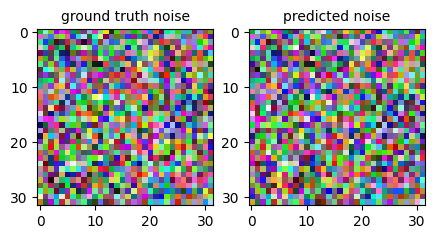

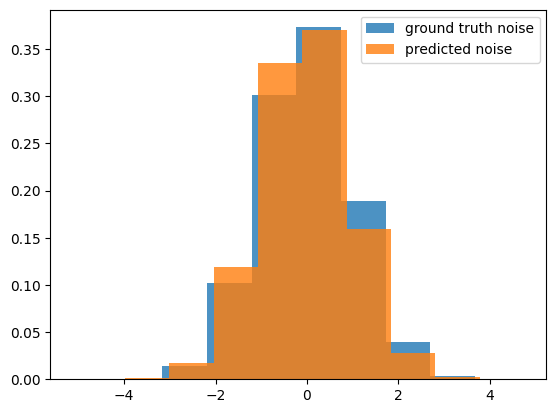

 20%|██        | 20/100 [1:12:47<4:47:16, 215.46s/it]

Execution Time 03:42:06PM | Duration 216.08747553825378


 21%|██        | 21/100 [1:16:22<4:43:28, 215.29s/it]

---
Epoch: 21 | Mean Train Loss 0.06841412690014412 | Mean Val Loss 0.06424068783720334
Execution Time 03:45:41PM | Duration 214.90431690216064


 22%|██▏       | 22/100 [1:19:57<4:39:41, 215.15s/it]

---
Epoch: 22 | Mean Train Loss 0.06794393701622119 | Mean Val Loss 0.06465515441810474
Execution Time 03:49:16PM | Duration 214.7996997833252


 23%|██▎       | 23/100 [1:23:31<4:35:57, 215.04s/it]

---
Epoch: 23 | Mean Train Loss 0.06770976214454724 | Mean Val Loss 0.06440546057927303
Execution Time 03:52:51PM | Duration 214.78724670410156


 24%|██▍       | 24/100 [1:27:06<4:32:15, 214.95s/it]

---
Epoch: 24 | Mean Train Loss 0.0674351578244032 | Mean Val Loss 0.06435439258049695
Execution Time 03:56:25PM | Duration 214.72974753379822


 25%|██▌       | 25/100 [1:30:41<4:28:41, 214.95s/it]

---
Epoch: 25 | Mean Train Loss 0.06714220945842755 | Mean Val Loss 0.06552942450612019
Execution Time 04:00:00PM | Duration 214.94826674461365


 26%|██▌       | 26/100 [1:34:16<4:25:05, 214.93s/it]

---
Epoch: 26 | Mean Train Loss 0.06658664029569197 | Mean Val Loss 0.06456810823426797
Execution Time 04:03:35PM | Duration 214.90046191215515


 27%|██▋       | 27/100 [1:37:51<4:21:26, 214.89s/it]

---
Epoch: 27 | Mean Train Loss 0.07716807210101531 | Mean Val Loss 0.06828335280983876
Execution Time 04:07:10PM | Duration 214.78512930870056


 28%|██▊       | 28/100 [1:41:25<4:17:44, 214.79s/it]

---
Epoch: 28 | Mean Train Loss 0.0691036792137684 | Mean Val Loss 0.06435618831370121
Execution Time 04:10:45PM | Duration 214.55355501174927


 29%|██▉       | 29/100 [1:45:00<4:14:04, 214.70s/it]

---
Epoch: 29 | Mean Train Loss 0.06793540770617815 | Mean Val Loss 0.06498151797896777
Execution Time 04:14:19PM | Duration 214.50484657287598
---
Epoch: 30 | Mean Train Loss 0.06784413252503443 | Mean Val Loss 0.06452767025583829


<Figure size 1500x1500 with 0 Axes>

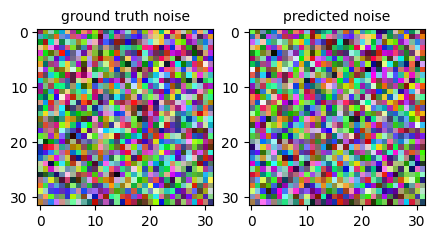

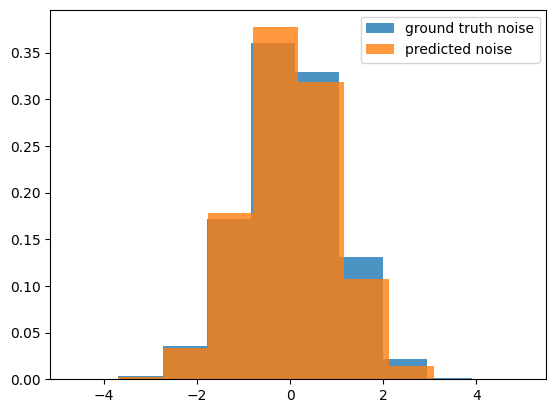

 30%|███       | 30/100 [1:48:35<4:10:44, 214.93s/it]

Execution Time 04:17:55PM | Duration 215.43893146514893


 31%|███       | 31/100 [1:52:10<4:07:01, 214.80s/it]

---
Epoch: 31 | Mean Train Loss 0.06670241712186581 | Mean Val Loss 0.0640975561661598
Execution Time 04:21:29PM | Duration 214.51981592178345


 32%|███▏      | 32/100 [1:55:44<4:03:20, 214.72s/it]

---
Epoch: 32 | Mean Train Loss 0.0672124215043508 | Mean Val Loss 0.0638552917024264
Execution Time 04:25:04PM | Duration 214.5022370815277


 33%|███▎      | 33/100 [1:59:19<3:59:39, 214.62s/it]

---
Epoch: 33 | Mean Train Loss 0.06639084802606167 | Mean Val Loss 0.06231591019492883
Execution Time 04:28:38PM | Duration 214.38318419456482


 34%|███▍      | 34/100 [2:02:53<3:56:06, 214.64s/it]

---
Epoch: 34 | Mean Train Loss 0.06644505761945858 | Mean Val Loss 0.06476362971350169
Execution Time 04:32:13PM | Duration 214.68964552879333


 35%|███▌      | 35/100 [2:06:28<3:52:30, 214.62s/it]

---
Epoch: 35 | Mean Train Loss 0.0666286667283529 | Mean Val Loss 0.06360421516001225
Execution Time 04:35:47PM | Duration 214.57892656326294


 36%|███▌      | 36/100 [2:10:03<3:48:53, 214.59s/it]

---
Epoch: 36 | Mean Train Loss 0.06620990772468921 | Mean Val Loss 0.06440866270508522
Execution Time 04:39:22PM | Duration 214.50723576545715


 37%|███▋      | 37/100 [2:13:37<3:45:16, 214.55s/it]

---
Epoch: 37 | Mean Train Loss 0.06729024345867145 | Mean Val Loss 0.06352135577262977
Execution Time 04:42:56PM | Duration 214.45181131362915


 38%|███▊      | 38/100 [2:17:11<3:41:36, 214.47s/it]

---
Epoch: 38 | Mean Train Loss 0.06629935953861628 | Mean Val Loss 0.06330608008190608
Execution Time 04:46:31PM | Duration 214.27323031425476


 39%|███▉      | 39/100 [2:20:46<3:38:09, 214.58s/it]

---
Epoch: 39 | Mean Train Loss 0.06592553111796196 | Mean Val Loss 0.06356227479110925
Execution Time 04:50:05PM | Duration 214.8302001953125
---
Epoch: 40 | Mean Train Loss 0.06606794621508855 | Mean Val Loss 0.0647751027956987


<Figure size 1500x1500 with 0 Axes>

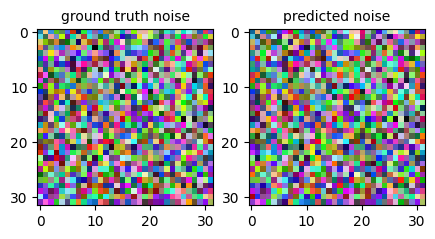

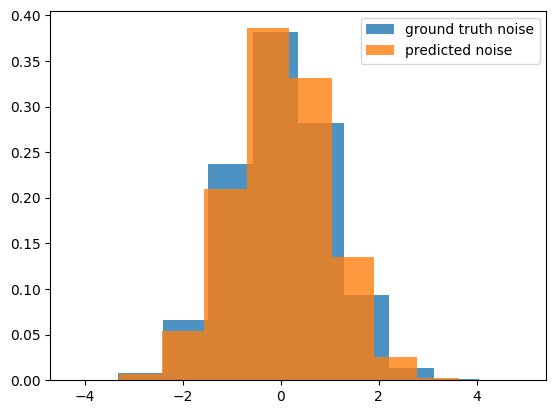

 40%|████      | 40/100 [2:24:22<3:34:53, 214.90s/it]

Execution Time 04:53:41PM | Duration 215.64392828941345


 41%|████      | 41/100 [2:27:56<3:31:15, 214.84s/it]

---
Epoch: 41 | Mean Train Loss 0.06648031029945765 | Mean Val Loss 0.06425691276597671
Execution Time 04:57:16PM | Duration 214.69499039649963


 42%|████▏     | 42/100 [2:31:31<3:27:36, 214.77s/it]

---
Epoch: 42 | Mean Train Loss 0.0657412062279689 | Mean Val Loss 0.06219046357541512
Execution Time 05:00:50PM | Duration 214.62115240097046


 43%|████▎     | 43/100 [2:35:06<3:23:57, 214.69s/it]

---
Epoch: 43 | Mean Train Loss 0.0658917011358799 | Mean Val Loss 0.06354807169200519
Execution Time 05:04:25PM | Duration 214.49779200553894


 44%|████▍     | 44/100 [2:38:40<3:20:19, 214.64s/it]

---
Epoch: 44 | Mean Train Loss 0.06611869530035899 | Mean Val Loss 0.06252226352882691
Execution Time 05:07:59PM | Duration 214.52516150474548


 45%|████▌     | 45/100 [2:42:15<3:16:44, 214.62s/it]

---
Epoch: 45 | Mean Train Loss 0.06579746644084271 | Mean Val Loss 0.0616800307463377
Execution Time 05:11:34PM | Duration 214.5672311782837


 46%|████▌     | 46/100 [2:45:49<3:13:08, 214.61s/it]

---
Epoch: 46 | Mean Train Loss 0.06572393806507955 | Mean Val Loss 0.06371138478891972
Execution Time 05:15:08PM | Duration 214.57255959510803


 47%|████▋     | 47/100 [2:49:24<3:09:34, 214.62s/it]

---
Epoch: 47 | Mean Train Loss 0.06608749605142153 | Mean Val Loss 0.06303562534352143
Execution Time 05:18:43PM | Duration 214.65687894821167


 48%|████▊     | 48/100 [2:52:59<3:06:01, 214.64s/it]

---
Epoch: 48 | Mean Train Loss 0.06588492513849185 | Mean Val Loss 0.06266510042433555
Execution Time 05:22:18PM | Duration 214.68518567085266


 49%|████▉     | 49/100 [2:56:33<3:02:28, 214.68s/it]

---
Epoch: 49 | Mean Train Loss 0.06618862056579346 | Mean Val Loss 0.06174100152192972
Execution Time 05:25:53PM | Duration 214.76996421813965
---
Epoch: 50 | Mean Train Loss 0.06604828701760525 | Mean Val Loss 0.06304395585679091


<Figure size 1500x1500 with 0 Axes>

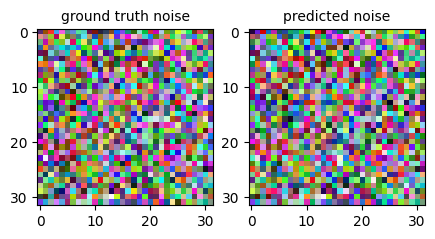

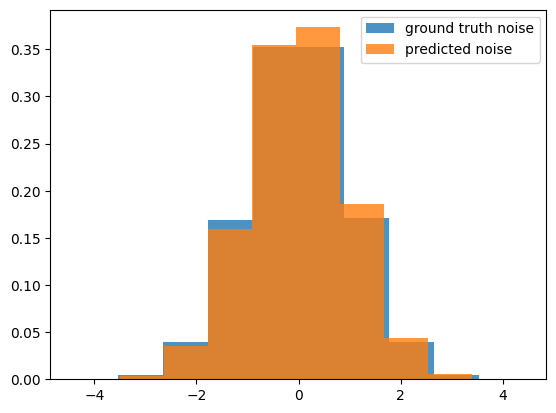

 50%|█████     | 50/100 [3:00:09<2:59:10, 215.02s/it]

Execution Time 05:29:28PM | Duration 215.79817461967468


 51%|█████     | 51/100 [3:03:44<2:55:31, 214.94s/it]

---
Epoch: 51 | Mean Train Loss 0.06589346489845178 | Mean Val Loss 0.06147244376822924
Execution Time 05:33:03PM | Duration 214.74378108978271


 52%|█████▏    | 52/100 [3:07:19<2:51:54, 214.89s/it]

---
Epoch: 52 | Mean Train Loss 0.06540899651172834 | Mean Val Loss 0.06351587009162475
Execution Time 05:36:38PM | Duration 214.76873993873596


 53%|█████▎    | 53/100 [3:10:54<2:48:20, 214.90s/it]

---
Epoch: 53 | Mean Train Loss 0.06481736043515877 | Mean Val Loss 0.06320542068435596
Execution Time 05:40:13PM | Duration 214.92507362365723


 54%|█████▍    | 54/100 [3:14:28<2:44:43, 214.85s/it]

---
Epoch: 54 | Mean Train Loss 0.06550578084320594 | Mean Val Loss 0.06428565352390973
Execution Time 05:43:48PM | Duration 214.73601937294006


 55%|█████▌    | 55/100 [3:18:03<2:41:07, 214.83s/it]

---
Epoch: 55 | Mean Train Loss 0.06523950316776068 | Mean Val Loss 0.06173719289020086
Execution Time 05:47:22PM | Duration 214.78444385528564


 56%|█████▌    | 56/100 [3:21:38<2:37:33, 214.85s/it]

---
Epoch: 56 | Mean Train Loss 0.06535132423234291 | Mean Val Loss 0.06059325835070549
Execution Time 05:50:57PM | Duration 214.89075374603271


 57%|█████▋    | 57/100 [3:25:13<2:33:56, 214.80s/it]

---
Epoch: 57 | Mean Train Loss 0.06493957285315563 | Mean Val Loss 0.06258812408225659
Execution Time 05:54:32PM | Duration 214.68521308898926


 58%|█████▊    | 58/100 [3:28:47<2:30:19, 214.74s/it]

---
Epoch: 58 | Mean Train Loss 0.06570785390451933 | Mean Val Loss 0.06294481809704731
Execution Time 05:58:07PM | Duration 214.5928201675415


 59%|█████▉    | 59/100 [3:32:22<2:26:42, 214.69s/it]

---
Epoch: 59 | Mean Train Loss 0.06518546956089827 | Mean Val Loss 0.06259980463446715
Execution Time 06:01:41PM | Duration 214.5765097141266
---
Epoch: 60 | Mean Train Loss 0.06537993631492822 | Mean Val Loss 0.06300616598664185


<Figure size 1500x1500 with 0 Axes>

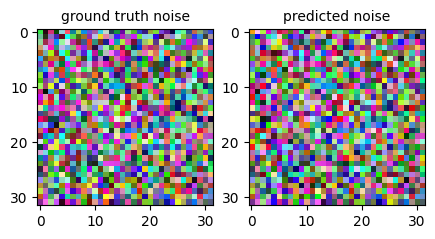

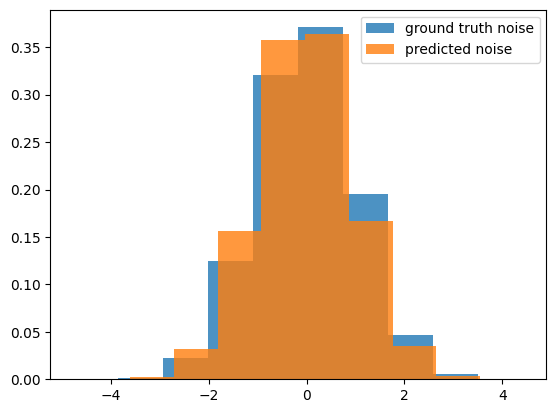

 60%|██████    | 60/100 [3:35:58<2:23:21, 215.03s/it]

Execution Time 06:05:17PM | Duration 215.80716609954834


 61%|██████    | 61/100 [3:39:32<2:19:43, 214.95s/it]

---
Epoch: 61 | Mean Train Loss 0.06547647047883424 | Mean Val Loss 0.06182938174177439
Execution Time 06:08:52PM | Duration 214.76927065849304


 62%|██████▏   | 62/100 [3:43:07<2:16:04, 214.86s/it]

---
Epoch: 62 | Mean Train Loss 0.0653378871579965 | Mean Val Loss 0.06254097547095555
Execution Time 06:12:26PM | Duration 214.6619689464569


 63%|██████▎   | 63/100 [3:46:42<2:12:28, 214.81s/it]

---
Epoch: 63 | Mean Train Loss 0.06563270855217408 | Mean Val Loss 0.06299652698903511
Execution Time 06:16:01PM | Duration 214.69037318229675


 64%|██████▍   | 64/100 [3:50:17<2:08:53, 214.81s/it]

---
Epoch: 64 | Mean Train Loss 0.06636405005477942 | Mean Val Loss 0.06282214944561322
Execution Time 06:19:36PM | Duration 214.7937195301056


 65%|██████▌   | 65/100 [3:53:52<2:05:19, 214.85s/it]

---
Epoch: 65 | Mean Train Loss 0.06442582762012115 | Mean Val Loss 0.06248461359586471
Execution Time 06:23:11PM | Duration 214.9564368724823


 66%|██████▌   | 66/100 [3:57:27<2:01:46, 214.90s/it]

---
Epoch: 66 | Mean Train Loss 0.06486874566628383 | Mean Val Loss 0.061379294794721484
Execution Time 06:26:46PM | Duration 215.01906418800354


 67%|██████▋   | 67/100 [4:01:02<1:58:12, 214.92s/it]

---
Epoch: 67 | Mean Train Loss 0.0645993198053195 | Mean Val Loss 0.06370788000715084
Execution Time 06:30:21PM | Duration 214.95978379249573


 68%|██████▊   | 68/100 [4:04:37<1:54:38, 214.94s/it]

---
Epoch: 68 | Mean Train Loss 0.06609300080782328 | Mean Val Loss 0.06487503342139415
Execution Time 06:33:56PM | Duration 214.98022150993347


 69%|██████▉   | 69/100 [4:08:12<1:51:04, 214.98s/it]

---
Epoch: 69 | Mean Train Loss 0.0657114024536732 | Mean Val Loss 0.06258236869978599
Execution Time 06:37:31PM | Duration 215.0703043937683
---
Epoch: 70 | Mean Train Loss 0.06474317147945746 | Mean Val Loss 0.06310104650373642


<Figure size 1500x1500 with 0 Axes>

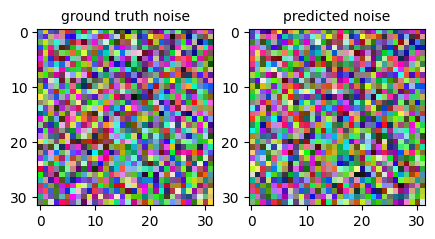

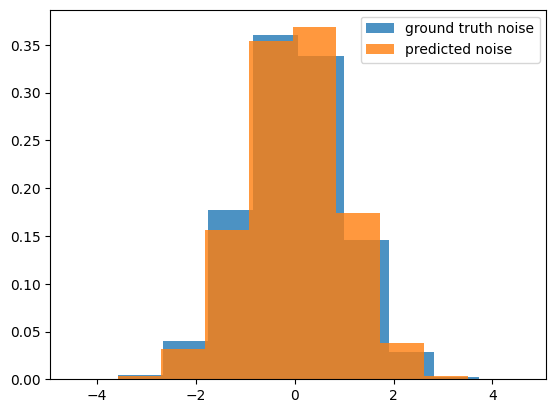

 70%|███████   | 70/100 [4:11:48<1:47:40, 215.35s/it]

Execution Time 06:41:07PM | Duration 216.21575784683228


 71%|███████   | 71/100 [4:15:23<1:44:03, 215.28s/it]

---
Epoch: 71 | Mean Train Loss 0.06553674945846583 | Mean Val Loss 0.06157221110203327
Execution Time 06:44:42PM | Duration 215.1075301170349


 72%|███████▏  | 72/100 [4:18:58<1:40:26, 215.24s/it]

---
Epoch: 72 | Mean Train Loss 0.06430343479300156 | Mean Val Loss 0.06417592094303706
Execution Time 06:48:17PM | Duration 215.12958431243896


 73%|███████▎  | 73/100 [4:22:33<1:36:49, 215.17s/it]

---
Epoch: 73 | Mean Train Loss 0.06581722006965907 | Mean Val Loss 0.06362802936480595
Execution Time 06:51:52PM | Duration 215.01355075836182


 74%|███████▍  | 74/100 [4:26:08<1:33:11, 215.07s/it]

---
Epoch: 74 | Mean Train Loss 0.0652758739124506 | Mean Val Loss 0.06315876352481353
Execution Time 06:55:27PM | Duration 214.82579708099365


 75%|███████▌  | 75/100 [4:29:43<1:29:34, 215.00s/it]

---
Epoch: 75 | Mean Train Loss 0.0653531225063862 | Mean Val Loss 0.06424877601556289
Execution Time 06:59:02PM | Duration 214.8324110507965


 76%|███████▌  | 76/100 [4:33:18<1:25:59, 214.97s/it]

---
Epoch: 76 | Mean Train Loss 0.06452096418883556 | Mean Val Loss 0.06323694815047276
Execution Time 07:02:37PM | Duration 214.90000367164612


 77%|███████▋  | 77/100 [4:36:53<1:22:24, 214.98s/it]

---
Epoch: 77 | Mean Train Loss 0.06515419833744183 | Mean Val Loss 0.06278485327194898
Execution Time 07:06:12PM | Duration 215.01304006576538


 78%|███████▊  | 78/100 [4:40:28<1:18:49, 214.99s/it]

---
Epoch: 78 | Mean Train Loss 0.06510524031443474 | Mean Val Loss 0.06148301456601192
Execution Time 07:09:47PM | Duration 215.01884841918945


 79%|███████▉  | 79/100 [4:44:03<1:15:14, 214.97s/it]

---
Epoch: 79 | Mean Train Loss 0.06469554796050757 | Mean Val Loss 0.06272819394675586
Execution Time 07:13:22PM | Duration 214.92325448989868
---
Epoch: 80 | Mean Train Loss 0.06472673587118968 | Mean Val Loss 0.062078189582396776


<Figure size 1500x1500 with 0 Axes>

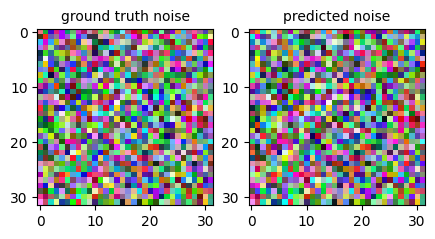

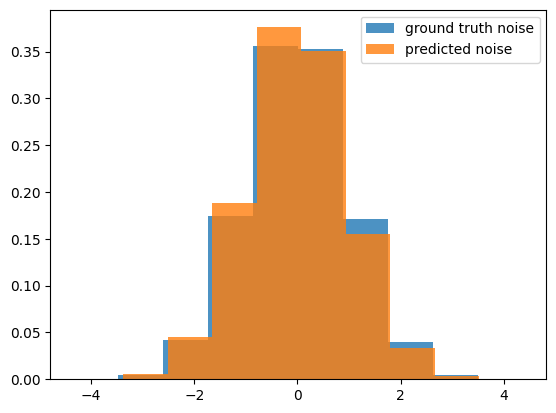

 80%|████████  | 80/100 [4:47:39<1:11:47, 215.36s/it]

Execution Time 07:16:58PM | Duration 216.25532937049866


 81%|████████  | 81/100 [4:51:14<1:08:08, 215.21s/it]

---
Epoch: 81 | Mean Train Loss 0.06510970029884423 | Mean Val Loss 0.06371550233318256
Execution Time 07:20:33PM | Duration 214.8486397266388


 82%|████████▏ | 82/100 [4:54:49<1:04:31, 215.09s/it]

---
Epoch: 82 | Mean Train Loss 0.06526311568151681 | Mean Val Loss 0.06319256079120514
Execution Time 07:24:08PM | Duration 214.82080006599426


 83%|████████▎ | 83/100 [4:58:24<1:00:56, 215.07s/it]

---
Epoch: 83 | Mean Train Loss 0.06521017974576888 | Mean Val Loss 0.06207964235009291
Execution Time 07:27:43PM | Duration 215.00511837005615


 84%|████████▍ | 84/100 [5:01:59<57:21, 215.10s/it]  

---
Epoch: 84 | Mean Train Loss 0.06438807222323539 | Mean Val Loss 0.06282411959881966
Execution Time 07:31:18PM | Duration 215.1786334514618


 85%|████████▌ | 85/100 [5:05:34<53:46, 215.09s/it]

---
Epoch: 85 | Mean Train Loss 0.06581221766387806 | Mean Val Loss 0.06308837497654633
Execution Time 07:34:53PM | Duration 215.0748360157013


 86%|████████▌ | 86/100 [5:09:09<50:10, 215.01s/it]

---
Epoch: 86 | Mean Train Loss 0.06476862911039438 | Mean Val Loss 0.06132522865365713
Execution Time 07:38:28PM | Duration 214.83136820793152


 87%|████████▋ | 87/100 [5:12:43<46:34, 214.96s/it]

---
Epoch: 87 | Mean Train Loss 0.06483759564849047 | Mean Val Loss 0.06222130000018156
Execution Time 07:42:03PM | Duration 214.83706784248352


 88%|████████▊ | 88/100 [5:16:18<42:59, 214.92s/it]

---
Epoch: 88 | Mean Train Loss 0.06474910853191829 | Mean Val Loss 0.06230270661986791
Execution Time 07:45:38PM | Duration 214.82550859451294


 89%|████████▉ | 89/100 [5:19:53<39:23, 214.87s/it]

---
Epoch: 89 | Mean Train Loss 0.06467112243557588 | Mean Val Loss 0.06306204562767959
Execution Time 07:49:12PM | Duration 214.74106121063232
---
Epoch: 90 | Mean Train Loss 0.0649828834602466 | Mean Val Loss 0.06252812398358798


<Figure size 1500x1500 with 0 Axes>

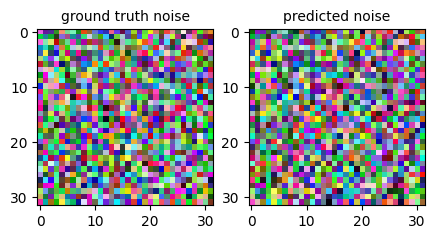

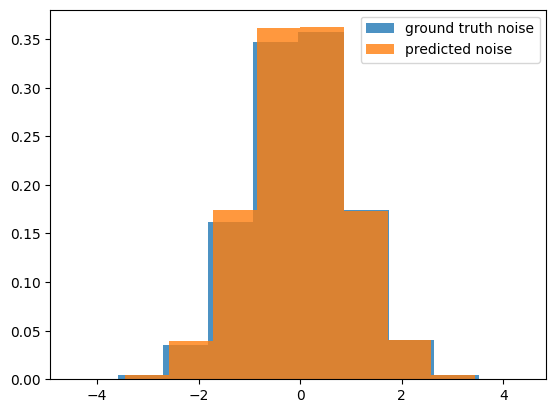

 90%|█████████ | 90/100 [5:23:29<35:52, 215.23s/it]

Execution Time 07:52:48PM | Duration 216.07014393806458


 91%|█████████ | 91/100 [5:27:04<32:16, 215.19s/it]

---
Epoch: 91 | Mean Train Loss 0.06461059048007696 | Mean Val Loss 0.06177306117919775
Execution Time 07:56:23PM | Duration 215.08359503746033


 92%|█████████▏| 92/100 [5:30:39<28:40, 215.07s/it]

---
Epoch: 92 | Mean Train Loss 0.06474560690231812 | Mean Val Loss 0.06324849034158084
Execution Time 07:59:58PM | Duration 214.79386591911316


 93%|█████████▎| 93/100 [5:34:14<25:04, 214.96s/it]

---
Epoch: 93 | Mean Train Loss 0.06508270031175552 | Mean Val Loss 0.06178495421623572
Execution Time 08:03:33PM | Duration 214.71691966056824


 94%|█████████▍| 94/100 [5:37:49<21:29, 214.93s/it]

---
Epoch: 94 | Mean Train Loss 0.06457080929898298 | Mean Val Loss 0.06340065073126401
Execution Time 08:07:08PM | Duration 214.83673071861267


 95%|█████████▌| 95/100 [5:41:23<17:53, 214.77s/it]

---
Epoch: 95 | Mean Train Loss 0.06518566383001131 | Mean Val Loss 0.06308002015336966
Execution Time 08:10:42PM | Duration 214.40253376960754


 96%|█████████▌| 96/100 [5:44:58<14:18, 214.74s/it]

---
Epoch: 96 | Mean Train Loss 0.06475992184609938 | Mean Val Loss 0.06217391120317655
Execution Time 08:14:17PM | Duration 214.65824389457703


 97%|█████████▋| 97/100 [5:48:32<10:44, 214.70s/it]

---
Epoch: 97 | Mean Train Loss 0.06524856194662743 | Mean Val Loss 0.06272952855588534
Execution Time 08:17:51PM | Duration 214.6098837852478


 98%|█████████▊| 98/100 [5:52:07<07:09, 214.64s/it]

---
Epoch: 98 | Mean Train Loss 0.06433860566944648 | Mean Val Loss 0.06019625005622705
Execution Time 08:21:26PM | Duration 214.5074360370636


 99%|█████████▉| 99/100 [5:55:41<03:34, 214.65s/it]

---
Epoch: 99 | Mean Train Loss 0.06419468423685966 | Mean Val Loss 0.06265906798533905
Execution Time 08:25:01PM | Duration 214.67007541656494
---
Epoch: 100 | Mean Train Loss 0.06551188306930737 | Mean Val Loss 0.06307033320459035


<Figure size 1500x1500 with 0 Axes>

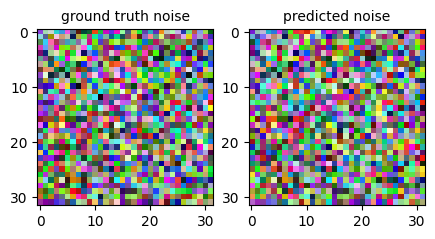

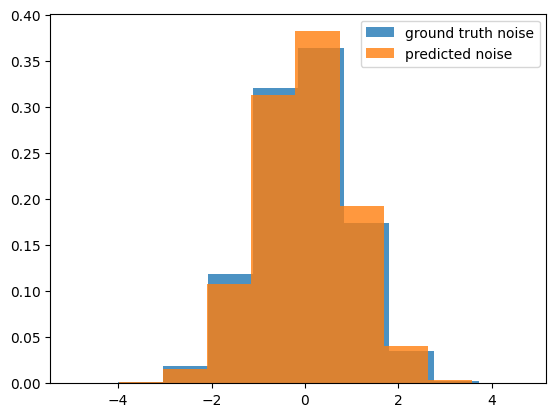

100%|██████████| 100/100 [5:59:17<00:00, 215.58s/it]

Execution Time 08:28:36PM | Duration 215.7950189113617


In [21]:
print(f"Training Start Time: {datetime.datetime.now().strftime('%I:%M:%S%p')}")
for epoch in tqdm.tqdm(range(NO_EPOCHS)):
    start = time.time()
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        loss_with_regularization = loss + WEIGHT_DECAY * sum(p.pow(2.0).sum() for p in unet.parameters())
        mean_epoch_loss.append(loss_with_regularization.item())
        loss_with_regularization.backward()
        optimizer.step()

    for batch, label in testloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())
        
    if (epoch+1) % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch+1} | Mean Train Loss {np.mean(mean_epoch_loss)} | Mean Val Loss {np.mean(mean_epoch_loss_val)}")
        if (epoch+1) % SAVE_FREQUENCY == 0:
            if VERBOSE:
                with torch.no_grad():
                    plot_noise_prediction(noise[0], predicted_noise[0])
                    plot_noise_distribution(noise, predicted_noise)

            torch.save(unet.state_dict(), f"epoch: {epoch+1}")

    print(f"Execution Time {datetime.datetime.now().strftime('%I:%M:%S%p')} | Duration {time.time() - start}")

In [20]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [21]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

# Generating images using saved weigths stored at all epochs to understand how much the model actually learnt in every 10 epochs.

In [25]:
unet_to_test = UNet(labels=True)
unet_to_test.load_state_dict(torch.load(("epoch: 100")))

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet_to_test.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

<Figure size 1500x1500 with 0 Axes>

In [22]:
unet_to_test = UNet(labels=True)
unet_to_test.load_state_dict(torch.load(("epoch: 100")))

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet_to_test.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>